In [31]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

from itertools import combinations


In [32]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

In [33]:
origin = load_data('mtcars')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab11_/mtcars.xlsx
[desc] 자동차 32종의 11개 속성에 대한 정보를 담고 있는 데이터 (출처: R 기본 데이터)

필드    타입      설명
------  --------  --------------------------------
name    str       차종 이름 (인덱스)
mpg     str       연료 효율성 (마일 당 갤런)
cyl     category  실린더 수
disp    float     배기량 (cubic inches)
hp      float     마력 (horsepower)
drat    float     후륜축 비율 (rear axle ratio)
wt      float     차량 무게 (1000 파운드)
qsec    float     1/4 마일 달성 시간 (초)
vs      category  엔진 유형 (0: V 엔진, 1: S 엔진)
am      category  변속기 형태 (0: 자동, 1: 수동)
gear    category  전진 기어 수 (전송 기어)
carb    category  기화기 개수 (carburetors)


===== 데이터 크기 확인 =====
데이터셋 크기: (32, 11)
열 개수: 11
행 개수: 32

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Mazda RX4 to Volvo 142E
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     32 non-null     float64
 1   cyl     32 non-null     int64  
 2   disp    32 non-null     float64
 3   hp      32

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
name,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


# 데이터 전처리

명목형 변수를 제외하고 나머지 칼럼만 남긴다.

In [34]:
df = origin.filter(['mpg', 'disp', 'hp', 'drat', 'wt', 'qsec'])
df.head()

,mpg,disp,hp,drat,wt,qsec
name,,,,,,
Mazda RX4,21.0,160.0,110,3.90,2.620,16.46
Mazda RX4 Wag,21.0,160.0,110,3.90,2.875,17.02
Datsun 710,22.8,108.0,93,3.85,2.320,18.61
Hornet 4 Drive,21.4,258.0,110,3.08,3.215,19.44
Hornet Sportabout,18.7,360.0,175,3.15,3.440,17.02


# 상관분석 가정 및 시각화

여러 변수일 때는 변수 쌍을 모두 교차해 상관을 본다.
우선 수치형 변수만 선택한 뒤,  왜도/이상치와 관계 형태를 확인한다.
선형성/단조성 : 페어플롯으로 형태 파악, 필요시 변수별 분포 확인
분포*이상치: 왜도와 z-score(>|3|)로 왜곡 여부 확인

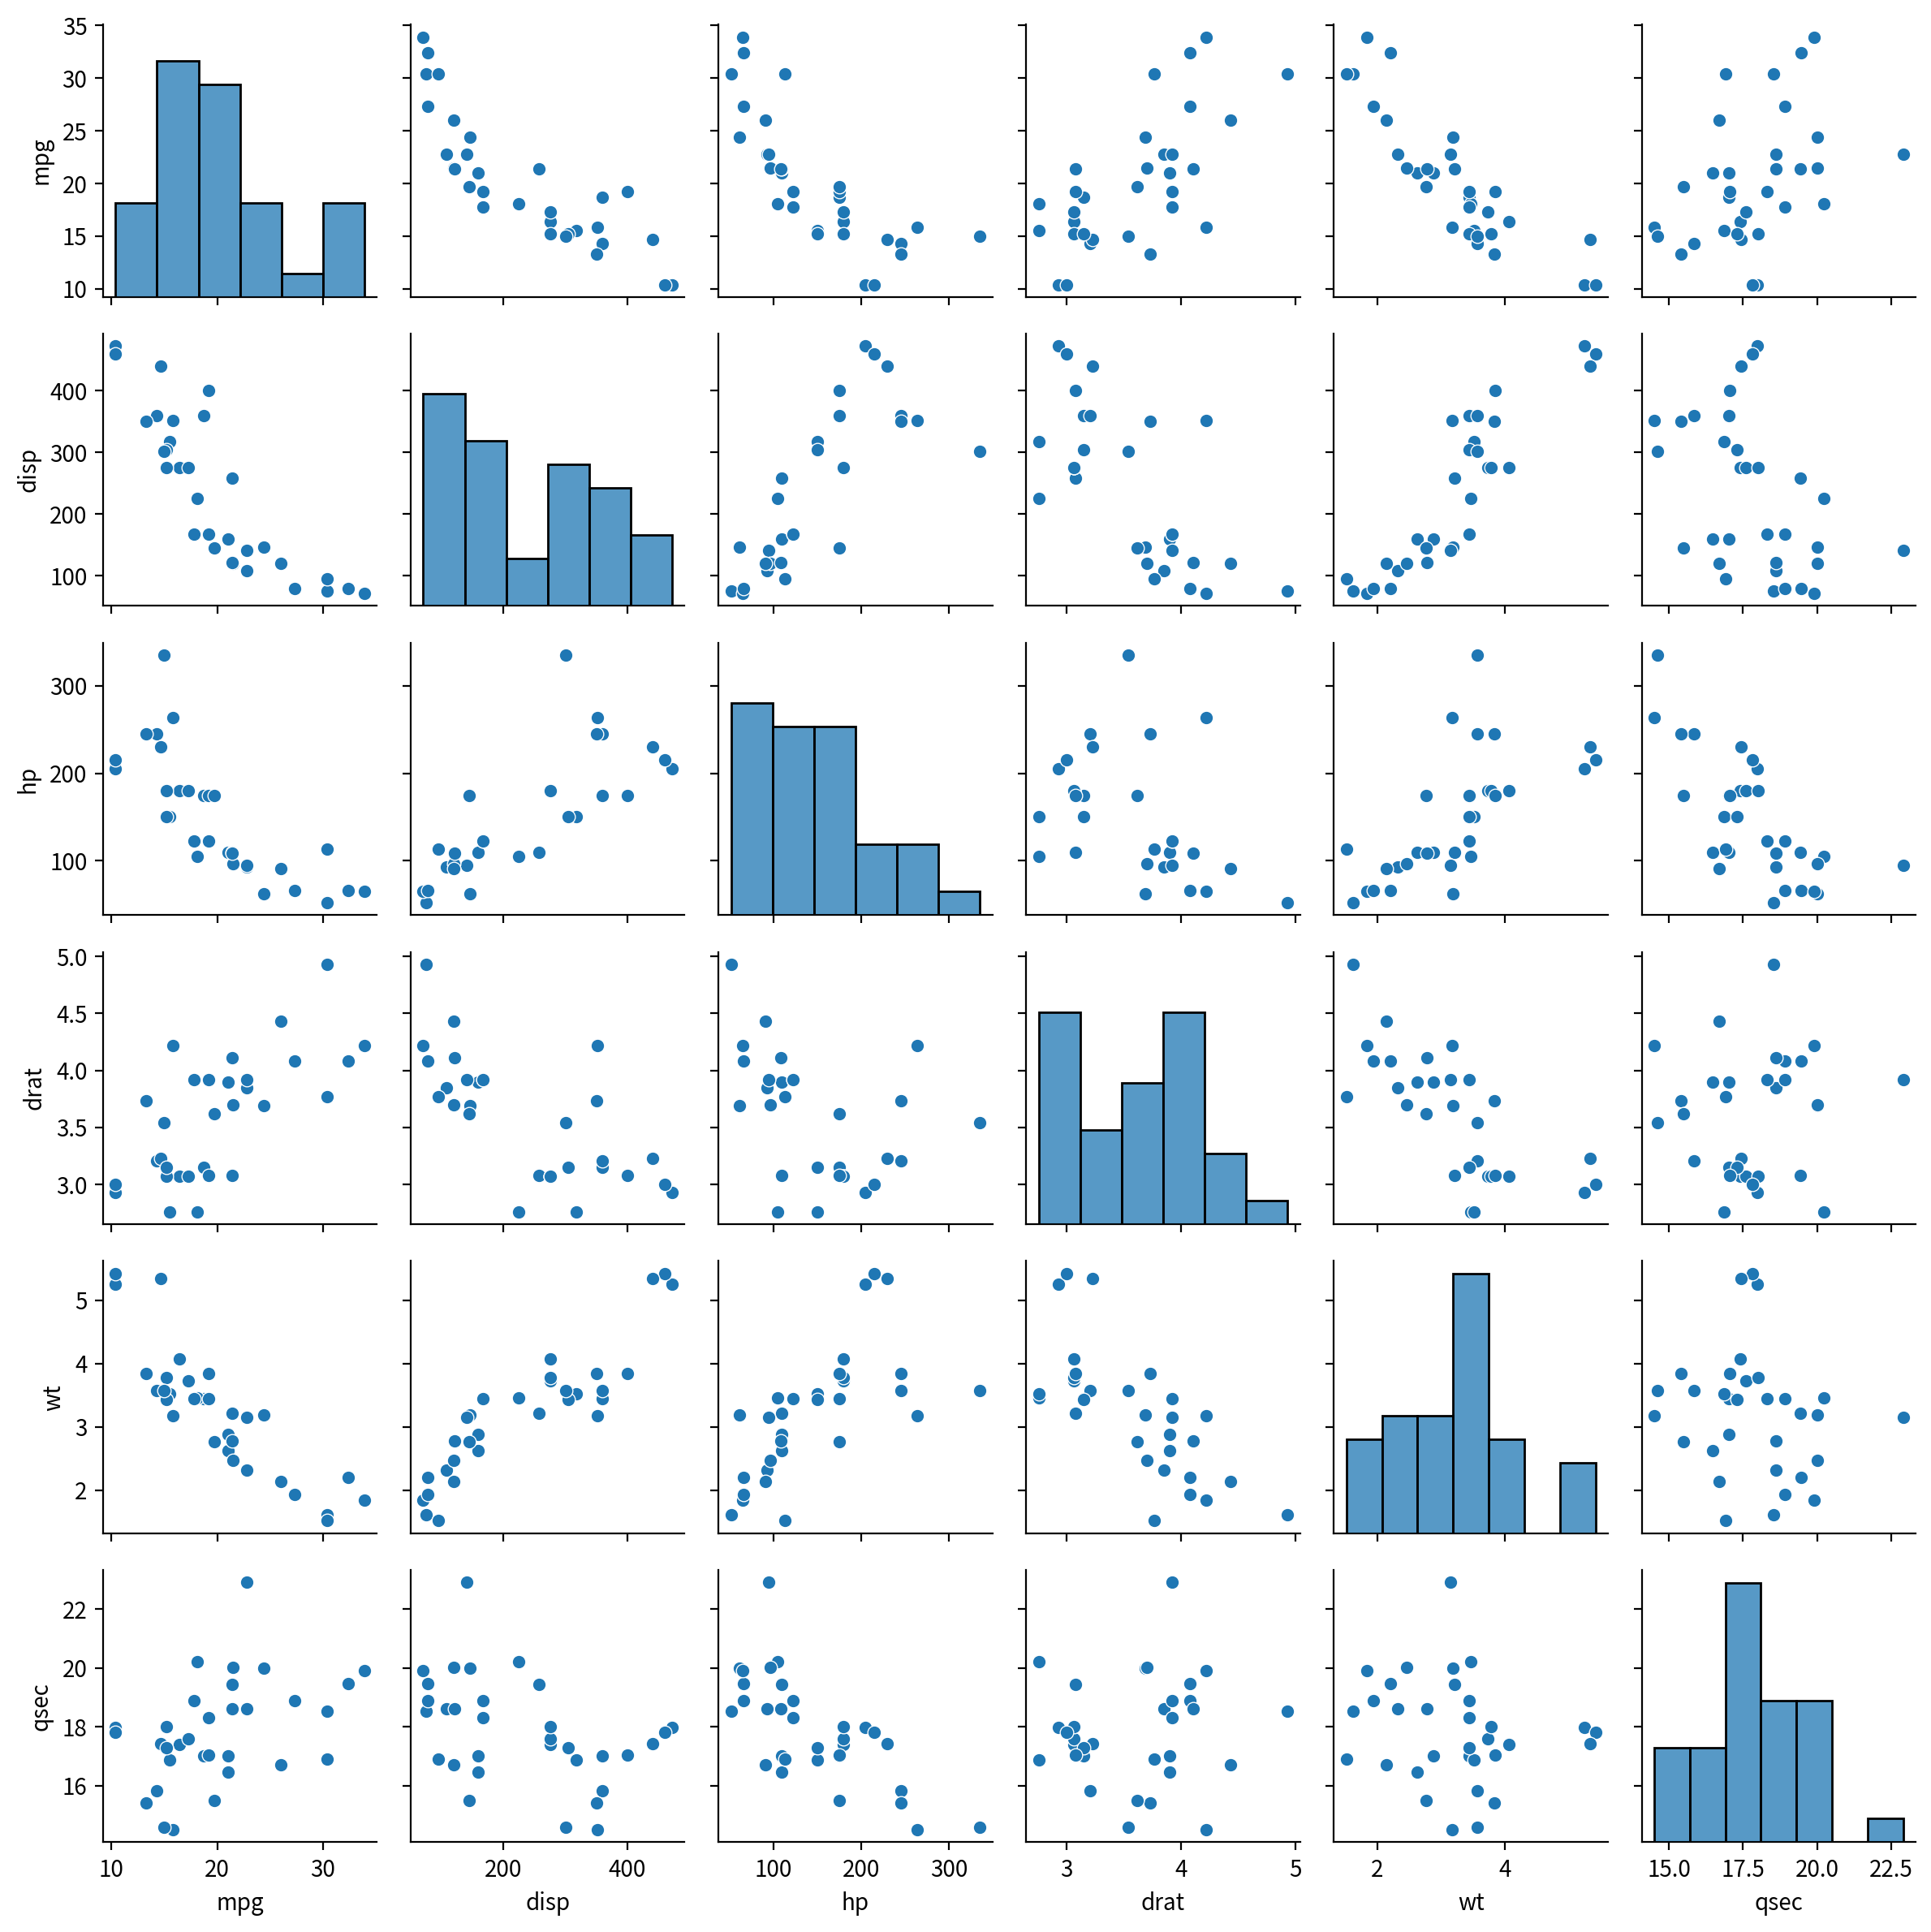

In [ ]:
#선형성-페어플롯으로 형태 확인
width_px = 2400
height_px = 2400
figsize = (width_px/ my_dpi, height_px/ my_dpi)

g = sb.pairplot(df, diag_kind='hist')
g.fig.set_size_inches(figsize)
g.fig.set_dpi(my_dpi)


plt.tight_layout()
plt.show()
plt.close()

In [39]:
#이상치 요약
skew_outlier = {}
for col in df.columns:
    temp = df[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores)>3))

    data_log = np.log1p(temp-temp.min()+1)
    skew_log = data_log.skew()
    skew_outlier[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count
        
    }
skew_outlier_df = DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z|>3)
mpg,0.672377,-0.960191,0.0
disp,0.420233,-1.292987,0.0
hp,0.799407,-1.466775,0.0
drat,0.292780,-0.044575,0.0
wt,0.465916,-0.298323,0.0
qsec,0.406347,-0.770281,0.0


# 변수 쌍별 상관 검정 및 방법 선택

기준: 변수 중 하나라도 왜도 큼/이상치 잇음/비선형 가능성->스피어만  우선,아니면 피어슨. 
두 계수를 모두 계산해비교하며, 선택된 계수와 p-value를 요약한다.

In [41]:
#intertools의 combinations함수 기능 확인
#주어진 리스트에서  r에 지정된 개수만큼 쌍으로 묶어 조합 가능한 모든 경우의수를 생성한다.
mylist = [10, 20, 30]
my_comb = combinations(mylist, r=2)

for c in my_comb:
    print(c)

(10, 20)
(10, 30)
(20, 30)


In [42]:
rows = []
for a, b in combinations(df.columns,2):
    x = df[a]
    y = df[b]

#선형성 확인
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue> 0.05

# 이상치 존재여부(|z|>3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z|>3)']>0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z|>3)']>0
    outlier_flag = a_flag or b_flag
#상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = 'person'
        corr, pval =pearsonr(x, y)
    
    else:
        chosen = 'spearman'
        corr, pval = spearmanr(x,y)

#유의성 판단(p<=0.05)
    significant = pval <=0.05


# 상관 강도 계산
    abs_r = abs(corr)
    if abs_r>= 0.80:
        strength = "Very strong"
    elif abs_r>= 0.60:
        strength = "Strong"
    elif abs_r>= 0.40:
        strength = "Medium"
    elif abs_r>= 0.20:
        strength = "Weak"
    else:
        strength = "Very weak"

    # 행 추가
    rows.append({
        "var_a":a,
        "var_b":b,
        "linearity": linearity_ok,
        "outlier_flag" :outlier_flag,
        "chosen": chosen, 
        "corr":corr,
        "pval":pval,
        "significant" :significant,
        "strength" :strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,mpg,disp,False,False,spearman,-0.908882,6.370336e-13,True,Very strong
1,mpg,hp,True,False,person,-0.776168,1.787835e-07,True,Strong
2,mpg,drat,True,False,person,0.681172,1.776240e-05,True,Strong
3,mpg,wt,False,False,spearman,-0.886422,1.487595e-11,True,Very strong
4,mpg,qsec,True,False,person,0.418684,1.708199e-02,True,Medium
5,disp,hp,True,False,person,0.790949,7.142679e-08,True,Strong
6,disp,drat,False,False,spearman,-0.683592,1.613884e-05,True,Strong
7,disp,wt,True,False,person,0.887980,1.222320e-11,True,Very strong
8,disp,qsec,True,False,person,-0.433698,1.314404e-02,True,Medium
9,hp,drat,False,False,spearman,-0.520125,2.277988e-03,True,Medium


# 결과 시각화
상관행렬 생성

In [37]:
# 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 빈 상관행렬 생성(Nan으로 초기화)
corr_matrix = DataFrame(np.nan, index = vars, columns=vars)

# summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r #대칭

# 대각선을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)
corr_matrix

,disp,drat,hp,mpg,qsec,wt
disp,1.000000,-0.683592,0.790949,-0.908882,-0.433698,0.887980
drat,-0.683592,1.000000,-0.520125,0.681172,0.091205,-0.712441
hp,0.790949,-0.520125,1.000000,-0.776168,-0.708223,0.774677
mpg,-0.908882,0.681172,-0.776168,1.000000,0.418684,-0.886422
qsec,-0.433698,0.091205,-0.708223,0.418684,1.000000,-0.174716
wt,0.887980,-0.712441,0.774677,-0.886422,-0.174716,1.000000


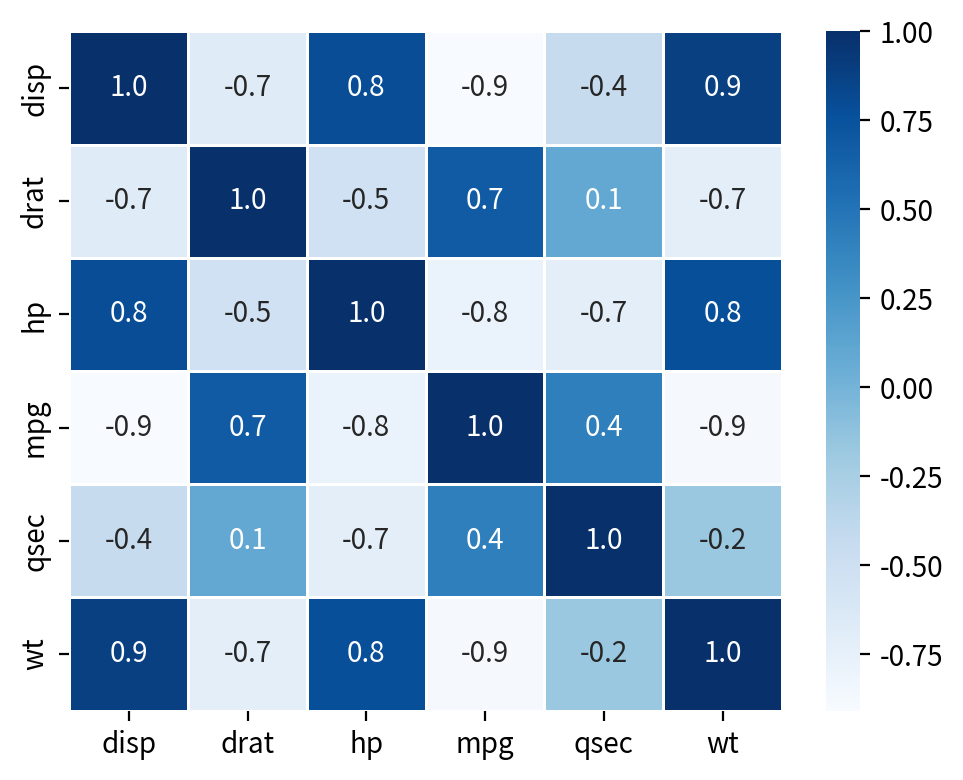

In [ ]:
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt = "0.1f", linewidth=0.5, cmap="Blues", annot_kws={"size":10})

 
plt.tight_layout()
plt.show()
plt.close()

본 연구에서는 주요 연속형 변수들 간의 상관구조를 파악하기 위해, 선형성 및 이상치 여부를 사
전 점검한 후 피어슨 또는 스피어만 상관계수를 선택적으로 적용하였다. 

분석 결과, mpg는 disp 및 wt와 매우 강한 음의 관계를 보였으며 hp 및 drat과도 강한 수준의
상관을 나타내 차량 연비와 기계적 특성 간의 밀접한 연관성을 확인할 수 있었다. disp는 wt 및
hp와 강한 양의 관계를 보여 엔진 배기량이 차량 중량 및 출력과 구조적으로 연계되어 있음을 시
사한다. 반면 drat–qsec 및 wt–qsec 조합에서는 유의한 상관이 나타나지 않아 변수 간 직접적
연관성이 약함을 보여주었다. 본 분석은 선형성 및 이상치 여부를 고려하여 적절한 상관계수를 선택하였으며, 이는 상관해석의 신뢰성을 높이는 데 기여하였다. 이러한 결과는 후속 회귀분석
또는 예측 모델 구축에서 변수 선택의 중요한 근거로 활용될 수 있다.
